# Final Project - The Rumos Bank Marketing Campaign
## Autor: José Costa

Depois do vosso sucesso no primeiro projecto no The Rumos Bank, surge um novo projecto ainda mais empolgante!

A equipa de marketing quer lançar uma nova campanha cujo objetivo é convencer os clientes a abrir depósitos a prazo.

Até agora a estratégia era ligar ao máximo número de pessoas, de forma indiscriminada, e tentar vender-lhe o produto. No entanto essa abordagem, para além de gastar mais recursos porque implica ter várias pessoas a ligar a todos os clientes, também é incomóda para alguns clientes que não gostam de ser incomodados com esse tipo de chamadas. Feitas as contas, chegou-se à conclusão que:

    - Por cada cliente identificado como um bom candidado, e é alvo da campanha mas não adere ao depósito a prazo, o banco tem um custo de 500euros.
    - Por cada cliente que é identificado como mau candidado, e como tal não é alvo da campanha mas na verdade era um bom candidado e iria aderir, o banco tem um custo de 2000euros.
    
Com base nesta informação, conseguem ajudar a equipa de marketing criando um modelo que seleccione os melhores candidatos para serem alvos da campanha, de forma a reduzir custos?


**O dataset contêm informação sobre todos os clientes que foram alvo da campanha:**

    1 - age
    2 - job : type of job
    3 - marital : marital status
    4 - education
    5 - default: has credit in default?
    6 - housing: has housing loan?
    7 - loan: has personal loan?
    8 - pdays: number of days that passed by after the client was last contacted from a previous campaign
    9 - previous: number of contacts performed before this campaign and for this client
    10 - poutcome: outcome of the previous marketing campaign
    11 - emp.var.rate: employment variation rate - quarterly indicator
    12 - cons.price.idx: consumer price index - monthly indicator
    13 - cons.conf.idx: consumer confidence index - monthly indicator
    14 - euribor3m: euribor 3 month rate - daily indicator
    15 - nr.employed: number of employees - quarterly indicator

**Output:**
    
    y: has the client subscribed a term deposit?
    
   

# Introdução

Este projecto tem como objetivo criar um modelo que consiga minimizar os custos que o banco tem na conquista de clientes para aderirem a um depósito a prazo.

De forma a alcançar esse objectivo os passos a seguir são:


*   Fazer uma pequena análise exploratória do dataset
*   Fazer uma primeira seleção dos melhores modelos utilizando a ROC curve
*   Dos melhores modelos escolher o que minimiza o custo do negócio
*   Verificar as features mais relevantes para identificar bons candidatos
*   Perceber o benefício que o modelo tem no custo da campanha ao banco
*   Verificar se o modelo escolhido tem estabilidade para diferentes random states

In [89]:
#importar as bibliotecas necessárias

import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import scipy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.compose import ColumnTransformer
from collections import defaultdict

SEED = 42

In [90]:
from google.colab import drive
drive.mount('/content/drive')

if not os.environ.get("RUMOS_ML_DATA_PATH"):
  from google.colab import drive
  drive.mount('/content/drive')

  root_path = '/content/drive/My Drive/Fundamentos_ML_Dados/'
else:
  root_path = os.environ.get("RUMOS_ML_DATA_PATH")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
data_path = os.path.join(root_path, 'bank_marketing_campaign.csv')
df = pd.read_csv(data_path) #ler e colocar os dados num dataframe
df.head()

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# 1. Quantas features estão disponíveis? Quantos clientes?

In [92]:
columns = df.shape[1] #número de colunas
rows = df.shape[0] #número de linhas

print(f"Número de features: {df.shape[1]}")
print(f"Nome das features: {df.columns.to_list()}")
print(f"Número de clientes: {df.shape[0]}")

Número de features: 16
Nome das features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
Número de clientes: 41188


O dataset tem 41188 clientes e 16 features, sendo uma delas a target (y).

# 2. Quantos clientes têm no dataset que efectivamente aderiram ao depósito a prazo? E quantos não o fizeram?

In [93]:
df['y'].value_counts() #verificar a quantidade de no e yes na coluna target(y)

,count
y,
no,36548
yes,4640


In [94]:
df['y'].value_counts()/len(df['y']) #percentagem de de no e yes na coluna target(y)

,count
y,
no,0.887346
yes,0.112654


O dataset tem 36548 (89%) clientes que não aderiram ao depósito e 4640 (11%) que aderiram. Neste caso temos um problema de classificação binária com uma classe target desbalanceada, existem mais pessoas que não aderem ao crédito.

 ####  Premissas

**True Positive** - Clientes identificados como bons candidatos que abriram depósito a prazo

**True Negative** - Clientes identificados como maus candidatos que não abrim depósito a prazo

**False Positive** - Clientes identificados como bons candidatos mas que não abriram depósito a prazo

**False Negative** - Clientes identificados como maus candidatos mas que abriram depósito a prazo

$$ TotalCost = 2000*FN + 500*FP $$

In [95]:
FP_COST = 500 #custo por cada cliente indentificado como bom candidato mas que não adere ao depósito
FN_COST = 2000 #custo por cada cliente identificado como mau candidato mas que adere ao depósito

## Análise Exploratória de dados

Antes de avançar para a escolha do modelo, primeiro vou realizar uma pequena análise exploratória aos dados.

In [96]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = SEED) #dividir o dataset entre treino e teste

train_set['y'] = train_set['y'].map({'yes': 1, 'no': 0}) #mudar a variável target para número -> yes:1, no:0
test_set['y'] = test_set['y'].map({'yes': 1, 'no': 0}) #mudar a variável target para número -> yes:1, no:0

### Missing Values

In [97]:
train_set.isnull().sum() #calcular o número de missing values para cada coluna dos dados de treino

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
pdays,0
previous,0
poutcome,0


In [98]:
test_set.isnull().sum() #calcular o número de missing values para cada coluna dos dados de teste

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
pdays,0
previous,0
poutcome,0


Verificamos que tanto os dados de treino como os de teste não têm missing values.

### Verificar Correlações

Verificar a correlação entre as variáveis númericas e categóricas com a target.

Para as variáveis númericas vou utilizar as correlações de Pearson e Spearman juntamente com o teste de mutual information.

Já para as variáveis categóricas vou usar o teste de Chi-square juntamente com o teste de mutual information.

#### Features Númericas

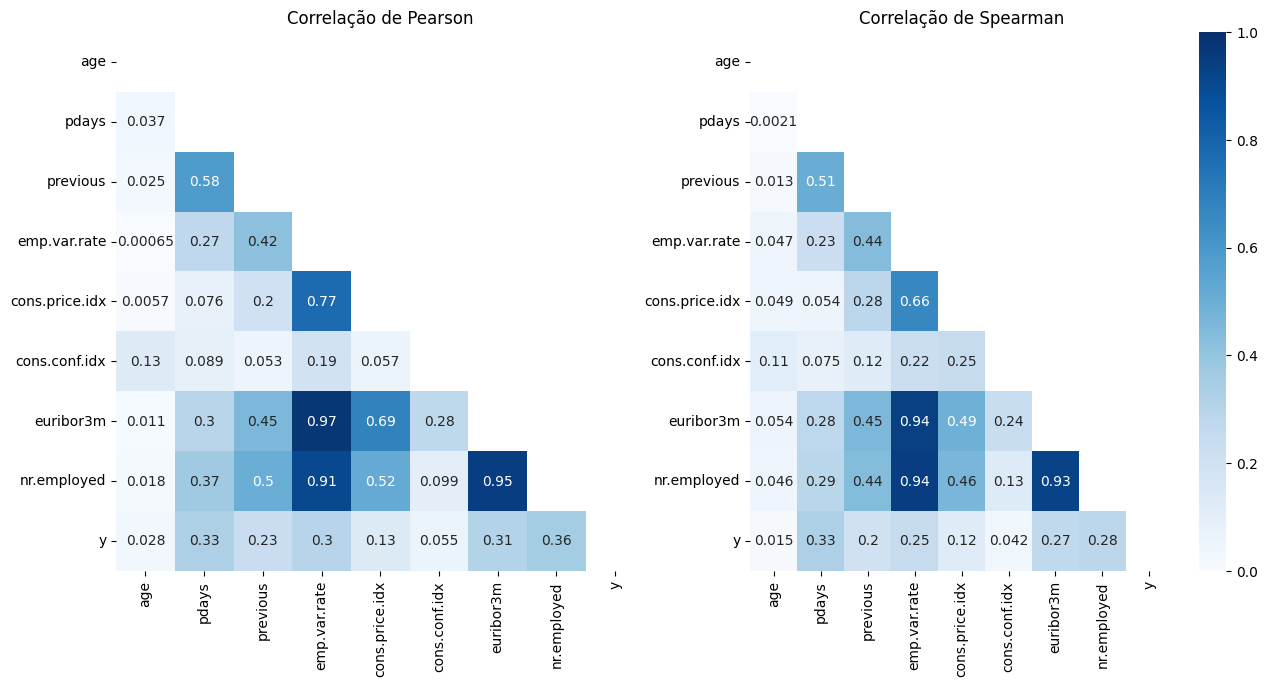

In [99]:
corr_pearson = train_set.select_dtypes(include='number').corr(method='pearson').abs() #calcular as correlações de pearson

corr_spearman = train_set.select_dtypes(include='number').corr(method='spearman').abs() #calcular as correlações de spearman

mask = np.triu(np.ones_like(corr_pearson)) #criar a máscara para retirar os valores duplicados (espelho)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7)) #criar uma figura com dois subplots e definir o tamanho da figura

#Adicionar à figura o heatmap com a correlação de pearson, escondendo a barra de legenda
sns.heatmap(corr_pearson,
            annot=True,
            cmap="Blues",
            vmin=0,
            vmax=1,
            mask=mask,
            ax=axes[0],
            cbar=False
)

axes[0].set_title("Correlação de Pearson") #definir o título para a correlação de pearson

#Adicionar à figura o heatmap com a correlação de spearman
sns.heatmap(corr_spearman,
            annot=True,
            cmap="Blues",
            vmin=0,
            vmax=1,
            mask=mask,
            ax=axes[1]
)

axes[1].set_title("Correlação de Spearman") #definir o título para a correlação de spearman

plt.show() #mostar a figura

Analisando os dois heatmaps acima, verificamos que as variáveis númericas mais correlacionadas tanto com o método de Pearson como com o de Spearman são:

*   emp.var.rate - nr.employed
*   emp.var.rate - euribor3m
*   euribor3m - nr.employed

In [100]:
mutual_info =  mutual_info_classif(train_set.select_dtypes(include='number').drop('y', axis=1), train_set['y'], random_state=SEED) #calcular a depêndencia entre as features e a target

mutual_df = pd.DataFrame(mutual_info, index=train_set.select_dtypes(include='number').drop('y', axis=1).columns, columns=['Mutual information']) #criar un dataframe com a informação
mutual_df

,Mutual information
age,0.012731
pdays,0.039582
previous,0.019856
emp.var.rate,0.057355
cons.price.idx,0.067655
cons.conf.idx,0.070425
euribor3m,0.071324
nr.employed,0.064698


Das variáveis númericas analisando as correlações de Pearson e Spearman aparentemente nenhuma tem uma correlação suficientemente forte com a target. O mesmo acontece quando analisamos a mutual information. Deste modo, apenas vou eliminar as variáveis emp.var.rate e euribor3m, por terem um forte correlação com nr.employed.

In [101]:
var_to_remove = ['emp.var.rate', 'euribor3m'] #variáveis para remover

#### Features Categóricas

In [102]:
categorical_data = train_set.select_dtypes(exclude='number') #selecionar variáveis categóricas
categorical_data['y'] = train_set['y']

In [103]:
#Realizar o teste Chi-square entre cada feature e a target

pval_list = [] #lista vazia para receber os p_values

for feat in categorical_data.drop('y', axis=1).columns:
    table = pd.crosstab(categorical_data[feat], categorical_data['y']) #criar a tabela de contigência entre cada feature e target

    _, pval, _, _ = scipy.stats.chi2_contingency(table) #realizar o teste do Chi-square e obter o p_value
    pval_list.append(pval) #anexar o p_value à lista

chi_square_df = pd.DataFrame(pval_list, index=categorical_data.drop('y',axis=1).columns, columns=['p_value']) #colocar os resultados num dataframe
chi_square_df

,p_value
job,5.087449e-149
marital,3.128028e-20
education,3.610340e-30
default,3.442664e-71
housing,9.631269e-02
loan,8.161321e-01
poutcome,0.000000e+00


In [104]:
#Transformar cada feature categórica em númerica para realizar o teste de mutual information com a target

encoder = LabelEncoder() #incia um objeto do tipo LabelEncoder

#Loop para transformar cada feature categórica em númerica
for feat in categorical_data.drop('y',axis=1).columns:
    encoder.fit(categorical_data[feat]) #fit do encoder para cada feature
    categorical_data[feat]= encoder.transform(categorical_data[feat]) #transformar a feature

In [105]:
mutual_info = mutual_info_classif(categorical_data.drop('y', axis=1), categorical_data['y'], random_state=SEED) #calcular a depêndencia entre as features e a target

mutual_df = pd.DataFrame(mutual_info, index=categorical_data.drop('y',axis=1).columns, columns=['Mutual information']) #criar un dataframe com a informação
mutual_df

,Mutual information
job,0.011976
marital,0.005537
education,0.001156
default,0.006866
housing,0.001244
loan,0.000000
poutcome,0.036967


Analisando o teste do Chi-square e considerando um threshold para o p_value de 0.05, verificamos que as variáveis housing e loan não têm relevância estatística com a target.
Usando o mutual information verificamos que nenhuma das features revela informação significativa sobre a target. No entanto, para uma primeira análise vou remover apenas housing e loan porque pelos dois métodos (chi-square e mutual information) ambas as variáveis parecem não ter relevância sobre a target.

In [106]:
var_to_remove.extend(['housing', 'loan']) #adicionar à lista de variáveis para remover housing e loan

### Escolha do Modelo

Neste passo, vou utilizar o Grid Search para escolher os melhores parâmetros e comparar os vários modelos de classificação. De forma a automatizar o tratamento das features, vou criar uma função que retorna um pipeline com os seguintes steps:


*   Pré processamento das features
  *   Normalização das variáveis númericas
  *   One hot encoding das variáveis categóricas
*   Estimador

<br>

Os modelos a ser testados são:

*   Neural Network (ann)
*   Random Forest
*   Decision Tree
*   Support Vector Machine (svm)
*   KNeighborsClassifier (knn)
*   Logistic Regression

In [107]:
#Para verificar se não há erros utilizar a linha abaixo, apenas usa 10% dos dados.
#train_set_staged = train_set.sample(frac=0.1, random_state=SEED)

train_set_staged = train_set

In [108]:
X_train = train_set_staged.drop(columns=['y'] + var_to_remove) #selecionar as features a utilizar no dataset de treino
y_train = train_set_staged['y'] #selecionar a target de treino

X_test = test_set.drop(columns=['y'] + var_to_remove) #selecionar as features a utilizar no dataset de teste
y_test = test_set['y'] #selecionar a target de teste

In [109]:
num_col_names = X_train.select_dtypes(include='number').columns.to_list() #nomes das features numéricas
cat_col_names = X_train.select_dtypes(exclude='number').columns.to_list() #nomes das features categóricas

#Função que retorna um Pipeline com os steps necessário para o modelo
def get_pipeline(estimator):

  #Pipeline com as transformações das features
  preprocessor = ColumnTransformer(
      transformers=[('num', Pipeline([('scaler', MinMaxScaler())]), num_col_names),
                    ('cat', Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]), cat_col_names)
                    ])

  #Pipeline com as tranformações e modelo
  pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
  return pipeline

In [110]:
#Dicionário com os vários modelos a testar
models = {
    'ann': MLPClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state = SEED),
    'DecisionTree': tree.DecisionTreeClassifier(random_state = SEED),
    'svm': SVC(random_state = SEED),
    'knn': KNeighborsClassifier(),
    'logistic': LogisticRegression(random_state = SEED)
}


#Dicionário com os parâmetros a testar para cada modelo
params = {
    'ann': {'estimator__hidden_layer_sizes': [(10), (20), (10, 5), (10, 20)], 'estimator__max_iter': [50, 100]},
    'RandomForest': {'estimator__n_estimators': [10, 100, 200], 'estimator__max_depth': [6, 8, 10], 'estimator__min_samples_split': [2, 4, 6], 'estimator__min_samples_leaf': [1, 2, 3]},
    'DecisionTree': {'estimator__max_depth': [3, 4, 5], 'estimator__min_samples_split': [3, 4, 5], 'estimator__criterion': ['gini'], 'estimator__splitter': ['best', 'random'], 'estimator__min_samples_leaf': [3, 4, 5, 6]},
    'svm': {'estimator__C': [0.1], 'estimator__gamma': np.logspace(-9, 3, 10), 'estimator__kernel': ['linear', 'rbf']},
    'knn': {'estimator__n_neighbors': [5, 10, 15]},
    'logistic': {'estimator__C': [15, 25, 50], 'estimator__solver': ['lbfgs', 'liblinear'], 'estimator__penalty': ['l2']}
}

In [111]:
grid_search_results = [] #lista vazia para receber os resultados do grid search para cada modelo

#Loop para iterar sobre os vários modelos e fazer o grid search
for name, model in models.items():
  print(f"Currently assessing {name}") #mostra o modelo que está a ser testado
  pipeline = get_pipeline(model) #cria o pipeline para o modelo a ser testado
  grid_result = GridSearchCV(pipeline, params[name], cv = 5).fit(X_train, y_train) #faz o grid search para o modelo a ser testado
  grid_search_results.append(grid_result) #anexa à lista o resultado

Currently assessing ann


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

Currently assessing RandomForest
Currently assessing DecisionTree
Currently assessing svm
Currently assessing knn
Currently assessing logistic


# 3. Qual/Quais as métricas de avaliação que usaram para comparar a performance dos vários modelos? Porquê?

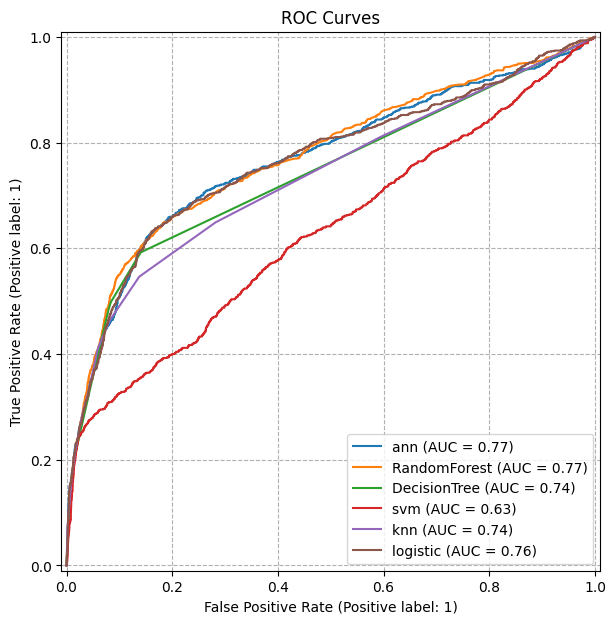

In [112]:
fig, ax_roc = plt.subplots(1, 1, figsize=(14, 7)) #cria uma figura com o tamanho com largura=12 e altura=8

#Loop que itera sobre cada modelo e calcula a curva de ROC com os dados de teste, utilizando o melhor estimador
for idx, model in enumerate(models.keys()):
  RocCurveDisplay.from_estimator(grid_search_results[idx].best_estimator_, X_test, y_test, ax=ax_roc, name=model)

ax_roc.set_title("ROC Curves") #define o título
ax_roc.grid(linestyle='--') #define o estilo de linha da grid, se quiser esconder visible=False

plt.legend() #mostra legenda
plt.show() #mostrar a figura

Numa comparação inicial dos modelos, de forma a escolher os que apresentam melhor resultado vou utilizar a *Receiver operating characteristic curve* (ROC).

Esta métrica é ideal para este caso em que temos uma target binária desbalanceada, pois de forma simples consigo ver quais modelos conseguem prever mais bons candidatos à campanha (TP) sem aumentar o número de contactos desnecessários (FP). Além disso, consigo verificar visualmente para os diferentes thresholds, se existe modelos mais interessantes.

Analisando as ROC curves acima representadas, concluimos que:


*   Até aos 20% de TPR todos os modelos tem a mesma performance
*   Dos 20% aos 40% de TPR a suport vector machine baixa a performance
*   Dos 40% aos 60% de TPR o knn deixa de ser interresante
*   Apartir do 60% de TPR os melhores modelos são ann, random forest e logistic

Assim sendo, após uma primeira análise vou selecionar a ann, random forest e a regressão logística, pois são os modelos que apresentam uma área debaixo da curva maior, e executar um segundo estudo já com o conhecimento de negócio para ver qual realmente apresenta melhor resultado.

É importante referir que a svm apresentou os piores resultados, no entanto poucos parâmetros foram testados, isto devido ao facto de ser um método que gasta muito tempo de computação.

In [113]:
#Seleção dos melhores modelos
best_models_index = [
    0, #ann
    1, #random forest
    5, #logistic regression
]

# 4. Qual o algoritmo que levou aos melhores resultados?

Após a seleção dos modelos que apresentaram melhor resultado na ROC curve, vou calcular o custo de negócio associado a cada modelo para os diferentes thresholds. No fim o objetivo é achar o threshold que diminui o custo de negócio, ou seja, quero saber a partir de qual probabilidade de um cliente aderir à campanha eu o devo contactar.

In [114]:
#Função para calcular o custo do negócio
def business_cost(tp, tn, fp, fn):
  return FP_COST*fp + FN_COST*fn

In [115]:
#Função para calcular o custo de negócio para cada threshold definido

def get_costs_per_thresholds(y_true, y_predict_proba, threshold_step=10):
  threshold_axis = [] #lista vazia para receber os thresholds
  business_cost_axis= [] #lista vazia para receber o custo para cada threshold

  #itera sobre cada threshold step e calcular o custo de negócio associado
  for i in range(0,101,threshold_step):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict_proba*100 >= i).ravel() #calcula a matrix de confusão
    current_cost = business_cost(tp, tn, fp, fn) #calcular o custo de negócio
    threshold_axis.append(i) #guarda o threshold
    business_cost_axis.append(current_cost) #guarda o custo
  return threshold_axis, business_cost_axis #retorna as listas com o threshold e custo associado

In [116]:
model_business_cost = defaultdict(list) #criar um dicionário para receber os resultados

#itera sobre cada modelo e calcula o custo de negócio para cada threshold
for model_index in best_models_index:
  #para o modelo em iteração calcula o custo de negócio para cada threshold
  x_axis, y_axis = get_costs_per_thresholds(
    y_test,
    grid_search_results[model_index].best_estimator_.predict_proba(X_test)[:,1]
  )

  model_business_cost['model'] = model_business_cost['model'] + [list(models.keys())[model_index]]*len(y_axis) #guarda o nome do modelo associado
  model_business_cost['business_cost'] = model_business_cost['business_cost'] + y_axis #guarda o custo de negócio associado ao threshold e modelo
  model_business_cost['threshold'] = model_business_cost['threshold'] + x_axis #guarda o threshold

model_business_cost_df = pd.DataFrame.from_dict(model_business_cost) #cria dataframe com os resultados

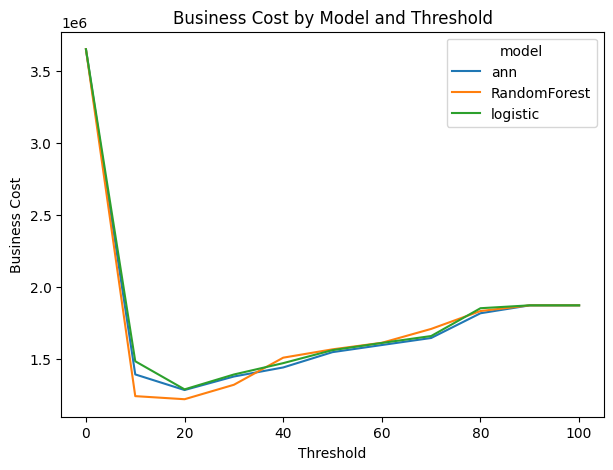

In [117]:
#plot com os custo associado a cada threshold e modelo
fig = plt.figure(figsize=(7,5))
sns.lineplot(model_business_cost_df, x="threshold", y="business_cost",hue="model")
plt.xlabel('Threshold')
plt.ylabel('Business Cost')
plt.title('Business Cost by Model and Threshold')
plt.show()

In [118]:
#seleciona o modelo e threshold com o custo de negócio mais baixo
model_business_cost_df.loc[model_business_cost_df["business_cost"]==model_business_cost_df["business_cost"].min()]

,model,business_cost,threshold
13,RandomForest,1217000,20


Analisando a figura acima, verificamos que a random forest com um threshold de 20 é o modelo que minimiza o custo de negócio, apresentando um custo total de 1.217 milhões de euros.

Assim sendo, com este modelo o banco só vai contactar clientes que tenham uma probabilidade igual ou superior a 20% de serem bons candidatos a aderirem ao crédito a prazo.

In [119]:
#seleciona o melhor estimador da random forest
selected_model = grid_search_results[1].best_estimator_

#seleciona o threshold e modelo que minimiza o custo de negócio
best_threshold_for_model = model_business_cost_df.loc[model_business_cost_df["business_cost"]==model_business_cost_df["business_cost"].min(),"threshold"].values[0]

In [120]:
#calcula a precision para o melhor threshold
random_forest_at_threshold_precision = precision_score(y_test, (selected_model.predict_proba(X_test)[:,1]*100 >= best_threshold_for_model))
#calcula o recall para o melhor threshold
random_forest_at_threshold_recall = recall_score(y_test, (selected_model.predict_proba(X_test)[:,1]*100 >= best_threshold_for_model))
#calcula a roc curve para o melhor threshold
random_forest_at_threshold_roc_auc = roc_auc_score(y_test, selected_model.predict_proba(X_test)[:,1])

print(f"Métricas para Random Forest com threshold={best_threshold_for_model}:\n")
print(f"\tprecision: {round(random_forest_at_threshold_precision,4)}")
print(f"\trecall: {round(random_forest_at_threshold_recall,4)}")
print(f"\troc auc: {round(random_forest_at_threshold_roc_auc,4)}")

Métricas para Random Forest com threshold=20:

	precision: 0.4303
	recall: 0.5219
	roc auc: 0.7728


Conclusões a tirar com as métricas obtidas:

* De todos os clientes que o modelo está a classificar como bons candidatos à campanha apenas 43% realmente são (precision).

* Do total de clientes que realmente são bons candidatos conseguimos prever 52% (recall/TPR).

# 5. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para aderir ao depósito a prazo?

In [121]:
#calcula o desvio padrão baseado na importância da feature em cada decision tree
std = np.std([tree.feature_importances_ for tree in selected_model.named_steps['estimator'].estimators_], axis=0)

In [122]:
#obter os nomes das features categróricas depois do encode
encoded_cat_features = selected_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

#juntar o nome das features númericas e categóricas
features_name = num_col_names + list(encoded_cat_features)

In [123]:
#criar dataframe com a importância e desvio padrão para cada feature
random_forest_importances = pd.DataFrame.from_dict({"feature": features_name, "importance":selected_model.named_steps['estimator'].feature_importances_, "std": std }).sort_values(by="importance",ascending=False)

#adicionar ao dataframe a importância cumulativa
random_forest_importances["importance_cumulative_percentage"] = random_forest_importances["importance"].cumsum() / random_forest_importances["importance"].sum()

In [124]:
random_forest_importances

,feature,importance,std,importance_cumulative_percentage
35,poutcome_success,0.243084,0.173820,0.243084
5,nr.employed,0.184360,0.176803,0.427444
4,cons.conf.idx,0.166330,0.114292,0.593774
3,cons.price.idx,0.107689,0.098198,0.701463
0,age,0.071085,0.040851,0.772548
1,pdays,0.047968,0.035215,0.820517
2,previous,0.043177,0.041578,0.863694
34,poutcome_nonexistent,0.041669,0.067008,0.905363
14,job_student,0.014521,0.013172,0.919884
33,poutcome_failure,0.014057,0.021492,0.933941


Ao analisar a importância, verificamos que grande parte das features categóricas agregam pouco valor ao modelo.

No entanto, mesmo as features com valores mais elevados de importância, como é o caso do poutcome_success e nr.employed, apresentam também valores elevados no desvio padrão. Isto significa que ao longo das várias trees a sua importância varia muito, o que mostra alguma instabilidade.

# 6. Qual é o custo que o banco tem sem nenhum modelo?

Sem nenhum modelo todos os clientes serão contactados indiscriminadamente, ou seja, estou a considerar que todos são bons candidatos à campanha. Assim sendo, aqueles que não aderiram (falsos positivos) vão representar um prejuízo.

FN = 0

FP = total de clientes que não aderiram

In [125]:
bad_clients = len(y_test) - sum(y_test) #total de clientes que não aderiram
total_cost_without_model = bad_clients * 500 #custo do banco sem modelo
print(f"O custo que o banco tem sem modelo é: {total_cost_without_model}€")

O custo que o banco tem sem modelo é: 3651500€


Sem qualquer modelo o banco tem um custo de 3651500 euros.

# 7. Qual o custo que o banco passa a ter com o vosso modelo?

In [126]:
total_cost_with_model = model_business_cost_df['business_cost'].min() #custo mínimo com modelo
print(f"Custo do banco com o modelo: {total_cost_with_model}€")
print(f"Redução de custo: {round((1 - total_cost_with_model/total_cost_without_model)*100, 2)}%")

Custo do banco com o modelo: 1217000€
Redução de custo: 66.67%


Com o modelo o banco passa a ter um custo de 1217000 euros, o que representa uma diminuição de cerca de 67%.

# 8. Testar a estabilidade do modelo para diferentes random states

Após ter escolhido o modelo e verificar o impacto deste no custo da campanha ao banco, vou testar o modelo para diferentes random states com o objectivo de perceber se ele se mantém estável ou se apresenta uma grande variabilidade nos valores das métricas.

In [127]:
results = [] #lista vazia para guardar as métricas para cada random state
best_threshold = 20

#Loop for para cada random state
for seed in range(40, 51):
  train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed) #divir o dataset em treino e teste para cada random state

  train_set['y'] = train_set['y'].map({'yes': 1, 'no': 0}) #mudar a variável target para número -> yes:1, no:0
  test_set['y'] = test_set['y'].map({'yes': 1, 'no': 0}) #mudar a variável target para número -> yes:1, no:0

  X_train = train_set.drop(columns=['y'] + var_to_remove)  #retirar as features que não uso e a target dos dados de treino
  y_train = train_set['y'] #isolar a target de treino

  X_test = test_set.drop(columns=['y'] + var_to_remove) #retirar as features que não uso e a target dos dados de teste
  y_test = test_set['y'] #isolar a target de teste

  model = RandomForestClassifier(max_depth=8, min_samples_split=6, n_estimators=10, random_state=seed) #definir o estimador com os melhores parâmetros
  pipeline = get_pipeline(model) #criar o pipeline para transformar e aplicar o estimador
  pipeline.fit(X_train, y_train) #fit do pipeline com os dados de treino
  predicted_proba = pipeline.predict_proba(X_test) #calcular as probabilidades para os dados de teste
  y_preds = (predicted_proba[:,1]*100 >= best_threshold) #definir as previsões com base nas probabilidade e no threshold definido

  precision = precision_score(y_test, y_preds)  #calcular a precision
  recall = recall_score(y_test, y_preds)  #calcular o recall
  roc_auc = roc_auc_score(y_test, predicted_proba[:,1]) #calcular a roc auc

  # guardar os resultados
  results.append({
        'random_state': seed,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    })

In [128]:
results_df = pd.DataFrame(results) #criar um dataframe com os resultados
results_df #mostrar dataframe

,random_state,precision,recall,roc_auc
0,40,0.457344,0.526316,0.772898
1,41,0.426966,0.551339,0.773767
2,42,0.430335,0.521925,0.772816
3,43,0.446791,0.546488,0.785929
4,44,0.441441,0.563218,0.779960
5,45,0.442446,0.523404,0.771517
6,46,0.400165,0.542506,0.779285
7,47,0.429802,0.518172,0.769893
8,48,0.456600,0.553728,0.785383
9,49,0.441558,0.549569,0.795434


Como podemos verificar no dataframe acima apresentado, o modelo para os diferentes random states apresenta métricas com valores muito semelhantes, isto quer dizer que os resultados que obtive para o random state 42 não foi um acaso. Assim sendo, o banco pode confiar na redução de custo que o modelo trará para a campanha.

# Conclusão

Em conclusão, conseguimos encontrar um modelo que consegue ajudar a equipa de marketing a seleccionar clientes com mais probabilidade de aderirem ao depósito a prazo e assim minimizar os custos que o banco teria sem nenhum modelo.

O modelo neste caso é o Random Forest com os parâmetros :

*   max_depth=8
*   min_samples_split=6
*   n_estimators=10

Com estes parâmetros, embora o modelo apenas consiga identificar 52% de todos os possíveis bons candidatos (TP) e dos que identifica apenas 43% o realmente são, consegue reduzir o custo da campanha em cerca de 67%.